In [1]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import seaborn as sns
from inducers import toxtree_hERG, toxtree_nav
from sklearn.metrics import f1_score, confusion_matrix
from math import sqrt
import numpy as np
#import warnings
#warnings.filterwarnings('ignore')

### Util-functions

In [2]:
def draw_confusion_matrix(ground_truth, predicted):
    ## Compute confusion matrix
    matrix = confusion_matrix(ground_truth, predicted)
    percentages = (matrix.T/matrix.sum(axis=1)).T
    ## Set cell format
    flattened_counts = [value for value in matrix.flatten()]
    flattened_percentages = ["{0:.2%}".format(value) for value in percentages.flatten()]
    labels = [f"{percentage}\n{value}" for value, percentage in 
                                      zip(flattened_counts,flattened_percentages)]
    labels = np.asarray(labels).reshape(matrix.shape[0],matrix.shape[0])
    ## create dataframe to set x/y-axis labels with focus on percentage
    percentDataframe = pd.DataFrame(percentages*100, 
                           columns = ['Non-blocker','Weak blocker','Moderate blocker','Strong blocker'],
                           index = ['Non-blocker','Weak blocker','Moderate blocker','Strong blocker'])
    ## Plot
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    sns.set_context('paper', font_scale=1.0)
    width = 7
    height = width / 1.6
    plt.figure(figsize=(width, height))
    ax = plt.axes()
    
    sns.heatmap(percentDataframe, annot = labels, fmt='',cmap= 'Blues', ax=ax, vmin=0, vmax=100, cbar_kws={'label': 'Accuracy'})
    ax.yaxis.set_tick_params(rotation=0)
    ax.set(xlabel='Predicted label', ylabel='True label')
    ax.title.set_text('Accuracy = {0:.1%}'.format(sum(1 for x,y in zip(ground_truth,predicted) if x == y) / len(ground_truth)))
    plt.show()

In [3]:
def PredictionString_to_IntLabel(predList):
    for val in predList:
        if val == 'Strong blocker':
            yield 3
        elif val == 'Moderate blocker':
            yield 2
        elif val == 'Weak blocker':
            yield 1
        else:
            yield 0

In [4]:
def pIC50_to_IntLabel(activityList):
    for val in activityList:
        if val >= 6:
            yield 3
        elif val >= 5:
            yield 2
        elif val >= 4.5:
            yield 1
        else:
            yield 0

In [5]:
def compute_metrics(ground_truth, predicted):
    print('Binary classification performace metrics:')
    print(confusion_matrix(ground_truth, predicted))
    tn, fp, fn, tp = confusion_matrix(ground_truth, predicted).ravel()
    print("TP, FN, TN, FP")
    print("{:02d}, {:02d}, {:02d}, {:02d}".format(tp, fn, tn, fp))
    print("AC: {0:.3f}".format((tp+tn)/(tp+tn+fn+fp)))
    print("SN: {0:.3f}".format((tp)/(tp+fn)))
    print("SP: {0:.3f}".format((tn)/(tn+fp)))
    print("CCR: {0:.3f}".format((((tp)/(tp+fn))+((tn)/(tn+fp)))/2))
    print("MCC: {0:.3f}".format((tp*tn-fp*fn)/(sqrt((tp+fn)*(tp+fp)*(tn+fn)*(tn+fp)))))
    print("f1: {0:.3f}".format(f1_score(ground_truth, predicted)))

### hERG Analysis

In [16]:
data_herg = pd.read_csv("data_sets/hERG_dataset.csv")
data_herg.head()

,SMILES,PIC50,LABEL,USED_AS,SOURCE
0,C[C@@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3...,4.85,Weak blocker,Dev-set,CHEMBL
1,C[C@@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3...,4.92,Weak blocker,Dev-set,CHEMBL
2,C[C@@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3...,5.00,Moderate blocker,Dev-set,CHEMBL
3,C[C@@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc5ccccn5)c3...,4.60,Weak blocker,Dev-set,CHEMBL
4,C[C@@H](O[C@H]1CCNC(=O)C[C@@H]1c2ccc(F)cc2)c3c...,5.00,Moderate blocker,Dev-set,CHEMBL


In [17]:
## Generate fingerprints
data_herg["mol_object"] = data_herg.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
data_herg["Fingerprint"] = data_herg.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)

In [18]:
## Compute TanimotoSimilarity
herg_ext_TanimotoSimilarity_traing = []
for idx, fp1 in enumerate(data_herg[data_herg["USED_AS"] == 'Ext_Eval_set']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_herg[data_herg["USED_AS"] == 'Dev-set']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        herg_ext_TanimotoSimilarity_traing.append(Tsim)
herg_ext_TanimotoSimilarity_test = []
for idx, fp1 in enumerate(data_herg[data_herg["USED_AS"] == 'Ext_Eval_set']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_herg[data_herg["USED_AS"] == 'Test-set']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        herg_ext_TanimotoSimilarity_test.append(Tsim)

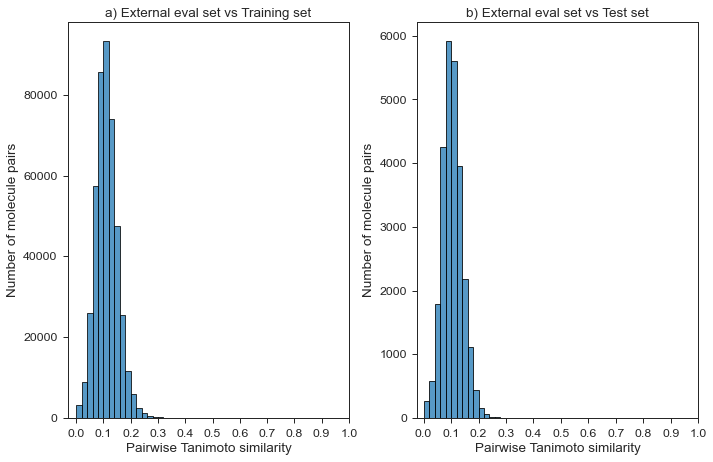

In [20]:
## plot external evaluation set Tanimoto Similarity distribution
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.4)    # Single-column figure.
width = 10
height = width / 1.618
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(width, height))

g1 = sns.histplot(herg_ext_TanimotoSimilarity_traing,fill=True, binwidth=0.02, ax=ax1)
g2 = sns.histplot(herg_ext_TanimotoSimilarity_test,fill=True, binwidth=0.02, ax=ax2)
fig.tight_layout()
ax1.set(xlabel='Pairwise Tanimoto similarity', ylabel='Number of molecule pairs')
ax1.title.set_text('a) External eval set vs Training set')
ax2.set(xlabel='Pairwise Tanimoto similarity', ylabel='Number of molecule pairs')
ax2.title.set_text('b) External eval set vs Test set')
plt.setp([ax1,ax2], xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

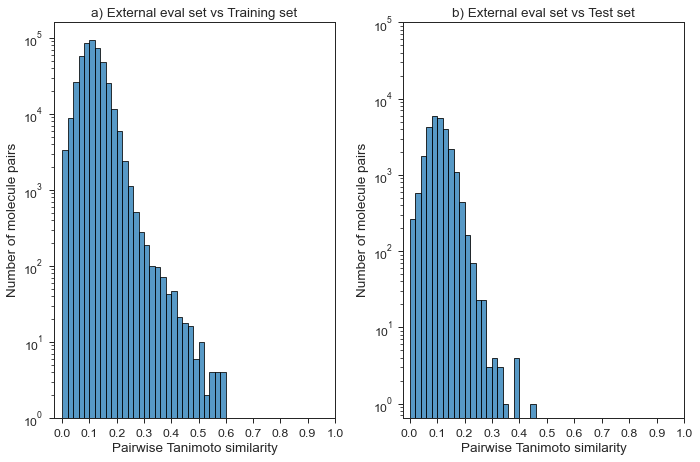

In [7]:
## plot external evaluation set Tanimoto Similarity distribution
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.4)    # Single-column figure.
width = 10
height = width / 1.618
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(width, height))

g1 = sns.histplot(herg_ext_TanimotoSimilarity_traing,fill=True, binwidth=0.02, ax=ax1)
g2 = sns.histplot(herg_ext_TanimotoSimilarity_test,fill=True, binwidth=0.02, ax=ax2)
fig.tight_layout()
ax1.set(xlabel='Pairwise Tanimoto similarity', ylabel='Number of molecule pairs')
ax1.title.set_text('a) External eval set vs Training set')
g1.set(yscale="log")
ax2.set(xlabel='Pairwise Tanimoto similarity', ylabel='Number of molecule pairs')
ax2.title.set_text('b) External eval set vs Test set')
g2.set(yscale="log")
plt.setp([ax1,ax2], xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], yticks=[1, 10, 100, 1000, 10000, 100000])
plt.show()
#plt.savefig('hERG_eval_set_Tanimoto_Similarity_distribution.png', dpi=400, bbox_inches='tight')

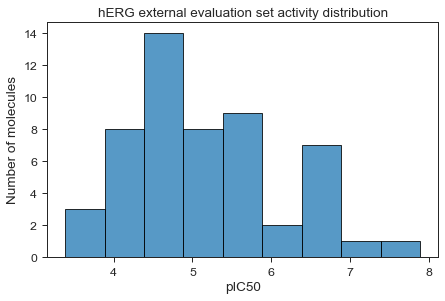

In [8]:
# Plot hERG external evaluation set activity distribution
width = 7
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))
sns.histplot(data_herg[data_herg["USED_AS"] == 'Ext_Eval_set']["PIC50"],fill=True, binwidth=0.5, ax=ax)
ax.set(xlabel='pIC50', ylabel='Number of molecules')
ax.title.set_text('hERG external evaluation set activity distribution')
plt.show()
#plt.savefig('hERG_eval_set_activity_distribution.png', dpi=400, bbox_inches='tight')

In [8]:
## ToxTree: hERG cardiotoxicity prediction
predictions = toxtree_hERG.hERG_infer("PaDEL/output/hERG/descriptor_values.csv")

|++++++++++++++++++++++++++++++++++++++++++++++|
|+++++ Legend: hERG liability predictions +++++|
|++++++++++++++++++++++++++++++++++++++++++++++|
|++++++ IC50 is reproted in microMolar ++++++++|
|++++++++++++++++++++++++++++++++++++++++++++++|
|    Strongblocker    =>  0<IC50<=1            |
|    Moderate blocker => 1<IC50<=10            |
|    Weakblocker      => 10<IC50<=30           |
|    Non-blocker      => 30<IC50               |
+++++++++++++++++++++++++++++++++++++++++++++++|

MC1: Non-blocker
MC2: Non-blocker
MC3: Weak blocker
MC4: Moderate blocker
MC5: Non-blocker
MC6: Non-blocker
MC7: Non-blocker
MC8: Non-blocker
MC9: Weak blocker
MC10: Non-blocker
MC11: Non-blocker
MC12: Weak blocker
MC13: Moderate blocker
MC14: Weak blocker
MC15: Weak blocker
MC16: Weak blocker
MC17: Strong blocker
MC18: Weak blocker
MC19: Weak blocker
MC20: Moderate blocker
MC21: Weak blocker
MC22: Weak blocker
MC23: Non-blocker
MC24: Weak blocker
MC25: Weak blocker
MC26: Moderate blocker
MC27: Moderate 

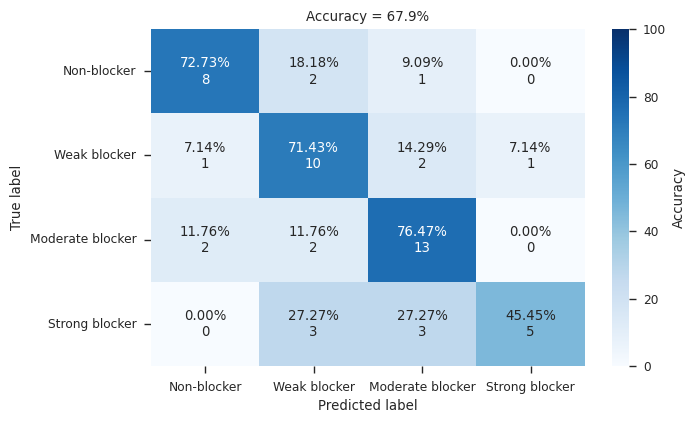

In [11]:
## Evaluation set results
ground_truth = [x for x in pIC50_to_IntLabel(data_herg[data_herg["USED_AS"] == 'Ext_Eval_set']["PIC50"])]
predicted = [x for x in PredictionString_to_IntLabel(predictions)]
draw_confusion_matrix(ground_truth, predicted)

In [12]:
ground_truth = [1 if x else x for x in pIC50_to_IntLabel(data_herg[data_herg["USED_AS"] == 'Ext_Eval_set']["PIC50"])]
predicted = [1 if x else x for x in PredictionString_to_IntLabel(predictions)]
compute_metrics(ground_truth, predicted)

Binary classification performace metrics:
[[ 8  3]
 [ 3 39]]
TP, FN, TN, FP
39, 03, 08, 03
AC: 0.887
SN: 0.929
SP: 0.727
CCR: 0.828
MCC: 0.656
f1: 0.929


### Nav1.5 Analysis

In [21]:
data_nav = pd.read_csv("data_sets/Nav1.5_dataset.csv")
data_nav.head()

,SMILES,PIC50,LABEL,USED_AS,SOURCE
0,Clc1ccc(c(c1)c2ccncc2)c3cccc4cc(ccc34)S(=O)(=O...,4.52,Weak blocker,Dev-set,CHEMBL
1,COCCOc1ccc2c(NC3(CCN(CC3)C(=O)c4ccc(OC)c(c4)N(...,5.65,Moderate blocker,Dev-set,CHEMBL
2,Fc1cc(OCC23CC4CC(CC(C4)C2)C3)c(cc1C(=O)NS(=O)(...,6.49,Strong blocker,Dev-set,CHEMBL
3,CCC1CN(c2ccc(cc2O1)S(=O)(=O)Nc3nccs3)c4ccc(cc4...,5.00,Moderate blocker,Dev-set,CHEMBL
4,CN(C)S(=O)(=O)NC(=O)c1cc(Cl)c(OC2CC3CC2C4CCCC3...,5.11,Moderate blocker,Dev-set,CHEMBL


In [22]:
## Generate fingerprints
data_nav["mol_object"] = data_nav.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
data_nav["Fingerprint"] = data_nav.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)

In [23]:
## Compute TanimotoSimilarity
nav_ext_TanimotoSimilarity_traing = []
for idx, fp1 in enumerate(data_nav[data_nav["USED_AS"] == 'Ext_Eval_set']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_nav[data_nav["USED_AS"] == 'Dev-set']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        nav_ext_TanimotoSimilarity_traing.append(Tsim)
nav_ext_TanimotoSimilarity_test = []
for idx, fp1 in enumerate(data_nav[data_nav["USED_AS"] == 'Ext_Eval_set']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_nav[data_nav["USED_AS"] == 'Test-set']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        nav_ext_TanimotoSimilarity_test.append(Tsim)

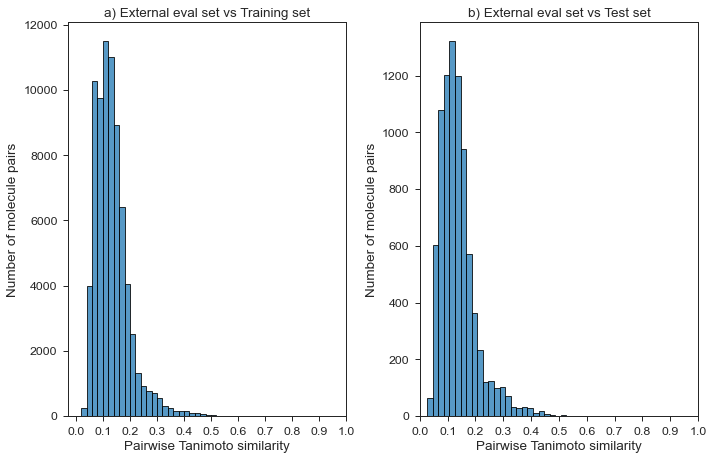

In [24]:
## plot
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.4)    # Single-column figure.
width = 10
height = width / 1.618
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(width, height))

g1 = sns.histplot(nav_ext_TanimotoSimilarity_traing,fill=True, binwidth=0.02, ax=ax1)
g2 = sns.histplot(nav_ext_TanimotoSimilarity_test,fill=True, binwidth=0.02, ax=ax2)
fig.tight_layout()
ax1.set(xlabel='Pairwise Tanimoto similarity', ylabel='Number of molecule pairs')
ax1.title.set_text('a) External eval set vs Training set')
ax2.set(xlabel='Pairwise Tanimoto similarity', ylabel='Number of molecule pairs')
ax2.title.set_text('b) External eval set vs Test set')
plt.setp([ax1,ax2], xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

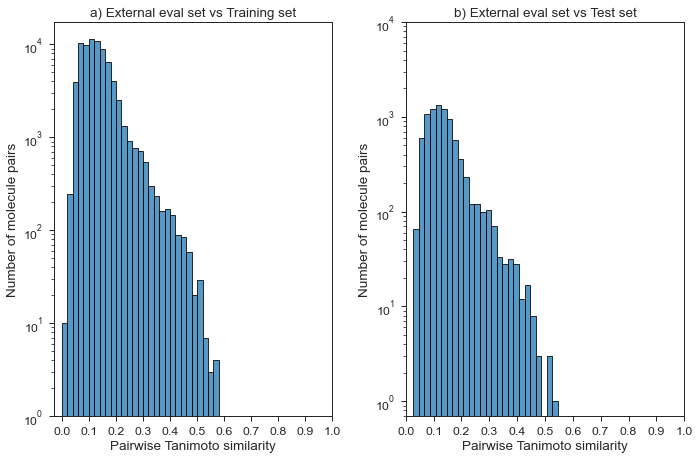

In [13]:
## plot
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.4)    # Single-column figure.
width = 10
height = width / 1.618
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(width, height))

g1 = sns.histplot(nav_ext_TanimotoSimilarity_traing,fill=True, binwidth=0.02, ax=ax1)
g2 = sns.histplot(nav_ext_TanimotoSimilarity_test,fill=True, binwidth=0.02, ax=ax2)
fig.tight_layout()
ax1.set(xlabel='Pairwise Tanimoto similarity', ylabel='Number of molecule pairs')
ax1.title.set_text('a) External eval set vs Training set')
g1.set(yscale="log")
ax2.set(xlabel='Pairwise Tanimoto similarity', ylabel='Number of molecule pairs')
ax2.title.set_text('b) External eval set vs Test set')
g2.set(yscale="log")
plt.setp([ax1,ax2], xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], yticks=[1, 10, 100, 1000, 10000])
plt.show()
#plt.savefig('Nav1.5_eval_set_Tanimoto_Similarity_distribution.png', dpi=400, bbox_inches='tight')

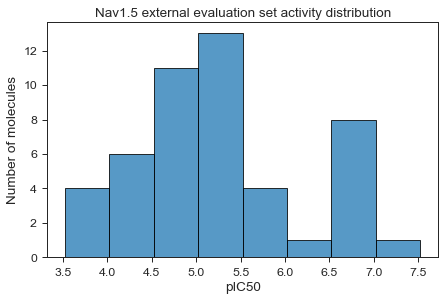

In [14]:
# Plot hERG external evaluation set activity distribution
width = 7
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))
sns.histplot(data_nav[data_nav["USED_AS"] == 'Ext_Eval_set']["PIC50"],fill=True, binwidth=0.5, ax=ax)
ax.set(xlabel='pIC50', ylabel='Number of molecules')
ax.title.set_text('Nav1.5 external evaluation set activity distribution')
plt.show()
#plt.savefig('Nav1.5_eval_set_activity_distribution.png', dpi=400, bbox_inches='tight')

In [14]:
## ToxTree: Nav1.5 cardiotoxicity prediction
predictions = toxtree_nav.Nav_infer("PaDEL/output/Nav1.5/descriptor_values.csv")

|++++++++++++++++++++++++++++++++++++++++++++++|
|++++ Legend: Nav1.5 liability predictions ++++|
|++++++++++++++++++++++++++++++++++++++++++++++|
|++++++ IC50 is reproted in microMolar ++++++++|
|++++++++++++++++++++++++++++++++++++++++++++++|
|    Strongblocker    =>  0<IC50<=1            |
|    Moderate blocker => 1<IC50<=10            |
|    Weakblocker      => 10<IC50<=30           |
|    Non-blocker      => 30<IC50               |
+++++++++++++++++++++++++++++++++++++++++++++++|

MC1: Weak blocker
MC2: Non-blocker
MC3: Moderate blocker
MC4: Moderate blocker
MC5: Non-blocker
MC6: Moderate blocker
MC7: Non-blocker
MC8: Non-blocker
MC9: Weak blocker
MC10: Non-blocker
MC11: Weak blocker
MC12: Non-blocker
MC13: Weak blocker
MC14: Weak blocker
MC15: Non-blocker
MC16: Weak blocker
MC17: Non-blocker
MC18: Moderate blocker
MC19: Weak blocker
MC20: Weak blocker
MC21: Weak blocker
MC22: Non-blocker
MC23: Moderate blocker
MC24: Moderate blocker
MC25: Moderate blocker
MC26: Moderate blocker
M

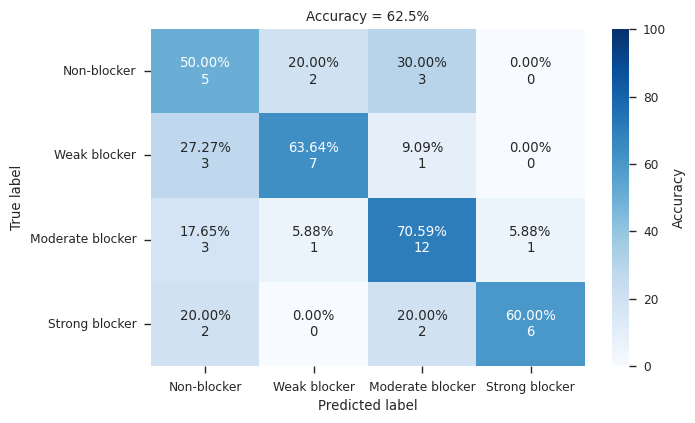

In [15]:
## Evaluation set results
ground_truth = [x for x in pIC50_to_IntLabel(data_nav[data_nav["USED_AS"] == 'Ext_Eval_set']["PIC50"])]
predicted = [x for x in PredictionString_to_IntLabel(predictions)]
draw_confusion_matrix(ground_truth, predicted)

In [16]:
ground_truth = [1 if x else x for x in pIC50_to_IntLabel(data_nav[data_nav["USED_AS"] == 'Ext_Eval_set']["PIC50"])]
predicted = [1 if x else x for x in PredictionString_to_IntLabel(predictions)]
compute_metrics(ground_truth, predicted)

Binary classification performace metrics:
[[ 5  5]
 [ 8 30]]
TP, FN, TN, FP
30, 08, 05, 05
AC: 0.729
SN: 0.789
SP: 0.500
CCR: 0.645
MCC: 0.265
f1: 0.822
